# 1. Import & Load Cleaned Data

In [1]:
import os
from pathlib import Path

project_root = Path('..').resolve()
os.chdir(project_root) 

print('Current working directory:', os.getcwd())

Current working directory: C:\Users\ibnum\Desktop\Material Learning\Credit Risk Project


In [2]:
import pandas as pd
from src.model.evaluate_model import confusion
from src.data import load_data, split_data
from src.config import config
from src.preprocessing import preprocessing
from src.model import build_model, evaluate_model, save_load, threshold
from src.model.threshold import ThresholdClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# 2. Build Preprocessing Components

In [3]:
# load cleaned data
df = load_data.read_data(file_path=config.CLEAN_DATA).drop(columns=['Unnamed: 0'])
df.head()

Data loaded succesfully from data/processed/credit_risk_cleaned.csv!
Data shape: (32409, 13)


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
1,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
2,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
3,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
4,21,9900,OWN,2.0,VENTURE,A,2500,7.14,1,0.25,N,2


In [4]:
# splitting data
X_train, X_test, y_train, y_test = split_data.split_train_test(data=df)

X_train shape: (25927, 11)
X_test shape: (6482, 11)
y_train shape: (25927,)
y_test shape: (6482,)


In [5]:
# build pipeline
num_pipeline, cat_pipeline = preprocessing.build_pipeline()

# build preprocessor
preprocessor = preprocessing.build_preprocessing(num_pipe=num_pipeline, cat_pipe=cat_pipeline)

In [6]:
y_train.value_counts(normalize=True)

loan_status
0    0.782543
1    0.217457
Name: proportion, dtype: float64

From that proportion above, I consider that the loan status categories are imbalance distributed. This case is important for the models to learn a lot of default customers pattern, but we have only 21% default customers data. For current situation, I am going to make 2 different treatments towards the models, which are using non-SMOTE and SMOTE to see the difference.

# 3. Fitting & Evaluation Models

**Evaluation Metrics will be used in this project**:

As explained on About Dataset & Project section, our main objective is to minimize the loss through preventing bad applicants (default customer get a loan). In the loan_status column, we clearly see that 1 (positive) stands for default and 0 (negative) stands for non-default.

So, the primary metrics that will be used in this project is Recall. In terms of classification error:
- False Negative (FN) = model predicts non-default (0) but customer is actually default (1) → This is very expensive for the business.
- False Positive (FP) = model predicts default (1) but customer is actually non-default (0) → This means rejecting a good customer → Business loses potential profit, but not as critical as losing money due to default.

But, I also want to use another metrics as the additional evaluation to consider from many perspectives. Here are my reasons below:
- Precision: We have another cost if we falsely predict good applicants as a bad applicants with losing potential revenue. So, I don't want to reject too many good applicants (avoid too many FP).
- F1 Score: I want to keep balancing on how my model could be able to detect any defaults and not default.
- ROC-AUC: More or less this metric similar to F1-score, I want to see how my model can differ the default and non-default judgement with precisely accurate (high score ROC-AUC)

I think those additional metrics (Precision, F1-score, and ROC-AUC) are on the same page to give me more insights that I have to build a fair model to judge whether the applicants are potentially default or not default. All of my model judgements will lead to the opportunity costs that the company have to pay.

## 3.1 Baseline Model

In [7]:
# predict baseline
y_base_pred, y_base_proba = build_model.build_baseline(X_train=X_train, y_train=y_train)

# evaluate baseline
recall_base, precision_base, f1_base, roc_auc_base = evaluate_model.evaluate_baseline(y_train=y_train, y_pred=y_base_pred, y_proba=y_base_proba)

In [8]:
print('Recall Baseline:', recall_base)
print('Precision Baseline:', precision_base)
print('F1-score Baseline:', f1_base)
print('ROC-AUC Baseline:', roc_auc_base)

Recall Baseline: 0.22401560837176304
Precision Baseline: 0.22018828451882846
F1-score Baseline: 0.22208545806224722
ROC-AUC Baseline: 0.5014219457886397


Our baseline recall score is only 22.56%. Actually, that score is quite low for our model standard. But, it also makes sense because of our loan_status data is imbalanced. By using strategy='stratified' in the Dummy Classifier, our baseline model actually learns to predict according to the target class proportion (loan_status), which is around 21–22%. This happens because our data can only predict the positive class (default = 1) within that range, so the baseline recall score should not be far from that percentage.

## 3.2 K-Nearest Neighbors

In [9]:
# define knn object
knn = KNeighborsClassifier()

# build cv model
knn_cv = build_model.build_cv_train(
    estimator=knn,
    preprocessor=preprocessor,
    params=config.KNN_PARAMS,
    X_train=X_train,
    y_train=y_train
)

# predict and evaluate cv-train
knn_best_param, knn_best_model, knn_recall_cv, knn_precision_cv, knn_f1_cv, \
knn_roc_auc_cv, knn_recall_train, knn_precision_train, knn_f1_train, knn_roc_auc_train = evaluate_model.evaluate_cv_train(
    estimator=knn_cv,
    X_train=X_train,
    y_train=y_train
)

Model KNeighborsClassifier has been created succesfully, time elapsed: 0.38 minutes.


## 3.3 Random Forest Classifier

In [10]:
# define random forest object
rf = RandomForestClassifier(random_state=123)

# build cv-train model
rf_cv = build_model.build_cv_train(
    estimator=rf,
    preprocessor=preprocessor,
    params=config.RF_PARAMS,
    X_train=X_train,
    y_train=y_train
)

# predict and evaluate cv-train
rf_best_param, rf_best_model, rf_recall_cv, rf_precision_cv, rf_f1_cv, \
rf_roc_auc_cv, rf_recall_train, rf_precision_train, rf_f1_train, rf_roc_auc_train = evaluate_model.evaluate_cv_train(
    estimator=rf_cv,
    X_train=X_train,
    y_train=y_train
)

Model RandomForestClassifier has been created succesfully, time elapsed: 3.69 minutes.


## 3.4 CatBoost Classifier

In [11]:
# define CatBoost object
cb = CatBoostClassifier(random_state=config.RANDOM_STATE, verbose=config.VERBOSE)

# predict CatBoost model
cb_cv = build_model.build_cv_train(
    estimator=cb,
    preprocessor=preprocessor,
    params=config.CATBOOST_PARAMS,
    X_train=X_train,
    y_train=y_train
)

# evaluate CatBoost model
cb_best_param, cb_best_model, cb_recall_cv, cb_precision_cv, cb_f1_cv, \
cb_roc_auc_cv, cb_recall_train, cb_precision_train, cb_f1_train, cb_roc_auc_train = evaluate_model.evaluate_cv_train(
    estimator=cb_cv,
    X_train=X_train,
    y_train=y_train
)

Model CatBoostClassifier has been created succesfully, time elapsed: 13.62 minutes.


## 3.5 XGBoost Classifier

In [12]:
# define XGB object
xgb = XGBClassifier(random_state=config.RANDOM_STATE, verbose=config.VERBOSE)

# predict XGB cv-train model
xgb_cv = build_model.build_cv_train(
    estimator=xgb,
    preprocessor=preprocessor,
    params=config.XGBOOST_PARAMS,
    X_train=X_train,
    y_train=y_train
)

# evaluate XGB cv-train model
xgb_best_param, xgb_best_model, xgb_recall_cv, xgb_precision_cv, xgb_f1_cv, \
xgb_roc_auc_cv, xgb_recall_train, xgb_precision_train, xgb_f1_train, xgb_roc_auc_train = evaluate_model.evaluate_cv_train(
    estimator=xgb_cv,
    X_train=X_train,
    y_train=y_train
)

Model XGBClassifier has been created succesfully, time elapsed: 1.23 minutes.


# 4. CV-Train Summary

In [13]:
summary_cv_train = pd.DataFrame(data={
    'model_name': ['Baseline', 'K-NN non-SMOTE', 'Random Forest non-SMOTE', 'CatBoost non-SMOTE', 'XGBoost non-SMOTE'],
    'recall_cv': ['-', knn_recall_cv, rf_recall_cv, cb_recall_cv, xgb_recall_cv],
    'recall_train': [recall_base, knn_recall_train, rf_recall_train, cb_recall_train, xgb_recall_train],
    'precision_cv': ['-', knn_precision_cv, rf_precision_cv, cb_precision_cv, xgb_precision_cv],
    'precision_train': [precision_base, knn_precision_train, rf_precision_train, cb_precision_train, xgb_precision_train],
    'f1_cv': ['-', knn_f1_cv, rf_f1_cv, cb_f1_cv, xgb_f1_cv],
    'f1_train': [f1_base, knn_f1_train, rf_f1_train, cb_f1_train, xgb_f1_train],
    'auc_cv': ['-', knn_roc_auc_cv, rf_roc_auc_cv, cb_roc_auc_cv, xgb_roc_auc_cv],
    'auc_train': [roc_auc_base, knn_roc_auc_train, rf_roc_auc_train, cb_roc_auc_train, xgb_roc_auc_train],
    'best_param': ['-', knn_best_param, rf_best_param, cb_best_param, xgb_best_param]
})

summary_cv_train.sort_values(by='recall_train', ascending=False).reset_index(drop=True)

,model_name,recall_cv,recall_train,precision_cv,precision_train,f1_cv,f1_train,auc_cv,auc_train,best_param
0,XGBoost non-SMOTE,0.758074,0.966832,0.984847,0.999633,0.836397,0.982959,0.870884,0.999860,"{'model__reg_lambda': 0.25, 'model__reg_alpha'..."
1,CatBoost non-SMOTE,0.750977,0.917347,0.98344,0.999420,0.838131,0.956626,0.868933,0.998267,"{'model__learning_rate': 0.2, 'model__iteratio..."
2,Random Forest non-SMOTE,0.718694,0.810394,0.972702,0.998689,0.82466,0.894742,0.855823,0.999008,"{'model__n_estimators': 100, 'model__min_sampl..."
3,K-NN non-SMOTE,0.61263,0.676126,0.894772,0.917670,0.710923,0.778595,0.790568,0.960966,{'model__n_neighbors': 5}
4,Baseline,-,0.224016,-,0.220188,-,0.222085,-,0.501422,-


# 5. Predict & Evaluate Test

In [14]:
# predict & evaluate using RF model
y_rf_pred , y_rf_proba = build_model.build_test(
    estimator=rf_best_model,
    X_test=X_test
)

rf_recall_test, rf_precision_test, rf_f1_test, rf_roc_auc_test = evaluate_model.evaluate_test(y_test=y_test, y_pred=y_rf_pred, y_proba=y_rf_proba)

# predict & evaluate using XGBoost model
y_xgb_pred, y_xgb_proba = build_model.build_test(
    estimator=xgb_best_model,
    X_test=X_test
)

xgb_recall_test, xgb_precision_test, xgb_f1_test, xgb_roc_auc_test = evaluate_model.evaluate_test(y_test=y_test, y_pred=y_xgb_pred, y_proba=y_xgb_proba)

# predict & evaluate using CatBoost model
y_cb_pred, y_cb_proba = build_model.build_test(
    estimator=cb_best_model,
    X_test=X_test
)

cb_recall_test, cb_precision_test, cb_f1_test, cb_roc_auc_test = evaluate_model.evaluate_test(y_test=y_test, y_pred=y_cb_pred, y_proba=y_cb_proba)

In [15]:
# summary train-test

train_test_summary = pd.DataFrame(data={
    'model_name': ['Random Forest non-SMOTE', 'CatBoost non-SMOTE', 'XGBoost non-SMOTE'],
    'recall_train': [rf_recall_train, cb_recall_train, xgb_recall_train],
    'recall_test': [rf_recall_test, cb_recall_test, xgb_recall_test],
    'precision_train': [rf_precision_train, cb_precision_train, xgb_precision_train],
    'precision_test': [rf_precision_test, cb_precision_test, xgb_precision_test],
    'f1_train': [rf_f1_train, cb_f1_train, xgb_f1_train],
    'f1_test': [rf_f1_test, cb_f1_test, xgb_f1_test],
    'roc_auc_train': [rf_roc_auc_train, cb_roc_auc_train, xgb_roc_auc_train],
    'roc_auc_test': [rf_roc_auc_test, cb_roc_auc_test, xgb_roc_auc_test]
})

train_test_summary.sort_values(by='recall_test', ascending=False).reset_index(drop=True)

,model_name,recall_train,recall_test,precision_train,precision_test,f1_train,f1_test,roc_auc_train,roc_auc_test
0,XGBoost non-SMOTE,0.966832,0.748966,0.999633,0.936207,0.982959,0.832184,0.999860,0.945339
1,CatBoost non-SMOTE,0.917347,0.742759,0.999420,0.943909,0.956626,0.831339,0.998267,0.941648
2,Random Forest non-SMOTE,0.810394,0.704138,0.998689,0.965941,0.894742,0.814519,0.999008,0.921144


All of those models are overfitting models, they couldn't be able to generalize the unseen data pretty well. I will use SMOTE approach to the dataset so hopefully we will be able to get the better models.

# 6. Using SMOTE for modeling

In [61]:
# define random forest object
rf = RandomForestClassifier(random_state=123)

# build cv-train model
rf_cv_smote = build_model.build_cv_train(
    estimator=rf,
    preprocessor=preprocessor,
    params=config.RF_PARAMS,
    X_train=X_train,
    y_train=y_train,
    is_smote=True
)

# predict and evaluate cv-train
rf_smote_best_param, rf_smote_best_model, rf_smote_recall_cv, rf_smote_precision_cv, rf_smote_f1_cv, \
rf_smote_auc_cv, rf_smote_recall_train, rf_smote_precision_train, rf_smote_f1_train, rf_smote_auc_train = evaluate_model.evaluate_cv_train(
    estimator=rf_cv_smote,
    X_train=X_train,
    y_train=y_train
)

# predict & evaluate test using RF model
y_rf_smote_pred, y_rf_smote_proba = build_model.build_test(
    estimator=rf_smote_best_model,
    X_test=X_test
)

rf_smote_recall_test, rf_smote_precision_test, rf_smote_f1_test, rf_smote_auc_test = evaluate_model.evaluate_test(y_test=y_test, y_pred=y_rf_smote_pred, y_proba=y_rf_smote_proba)

Model RandomForestClassifier has been created succesfully, time elapsed: 6.95 minutes.


In [62]:
# define catboost object
cb = CatBoostClassifier(random_state=config.RANDOM_STATE, verbose=config.VERBOSE)

# build cv-train model
cb_cv_smote = build_model.build_cv_train(
    estimator=cb,
    preprocessor=preprocessor,
    params=config.CATBOOST_PARAMS,
    X_train=X_train,
    y_train=y_train,
    is_smote=True
)

# predict and evaluate cv-train
cb_smote_best_param, cb_smote_best_model, cb_smote_recall_cv, cb_smote_precision_cv, cb_smote_f1_cv, \
cb_smote_auc_cv, cb_smote_recall_train, cb_smote_precision_train, cb_smote_f1_train, cb_smote_auc_train = evaluate_model.evaluate_cv_train(
    estimator=cb_cv_smote,
    X_train=X_train,
    y_train=y_train
)

# predict & evaluate test using cb model
y_cb_smote_pred, y_cb_smote_proba = build_model.build_test(
    estimator=cb_smote_best_model,
    X_test=X_test
)

cb_smote_recall_test, cb_smote_precision_test, cb_smote_f1_test, cb_smote_auc_test = evaluate_model.evaluate_test(y_test=y_test, y_pred=y_cb_smote_pred, y_proba=y_cb_smote_proba)

Model CatBoostClassifier has been created succesfully, time elapsed: 38.91 minutes.


In [63]:
# define xgboost object
xgb = XGBClassifier(random_state=config.RANDOM_STATE, verbose=config.VERBOSE)

# build cv-train model
xgb_cv_smote = build_model.build_cv_train(
    estimator=xgb,
    preprocessor=preprocessor,
    params=config.XGBOOST_PARAMS,
    X_train=X_train,
    y_train=y_train,
    is_smote=True
)

# predict and evaluate cv-train
xgb_smote_best_param, xgb_smote_best_model, xgb_smote_recall_cv, xgb_smote_precision_cv, xgb_smote_f1_cv, \
xgb_smote_auc_cv, xgb_smote_recall_train, xgb_smote_precision_train, xgb_smote_f1_train, xgb_smote_auc_train = evaluate_model.evaluate_cv_train(
    estimator=xgb_cv_smote,
    X_train=X_train,
    y_train=y_train
)

# predict & evaluate test using xgb model
y_xgb_smote_pred, y_xgb_smote_proba = build_model.build_test(
    estimator=xgb_smote_best_model,
    X_test=X_test
)

xgb_smote_recall_test, xgb_smote_precision_test, xgb_smote_f1_test, xgb_smote_auc_test = evaluate_model.evaluate_test(y_test=y_test, y_pred=y_xgb_smote_pred, y_proba=y_xgb_smote_proba)

Model XGBClassifier has been created succesfully, time elapsed: 4.73 minutes.


In [64]:
# make smote summary
smote_summary = pd.DataFrame(data={
    'model_name': ['Random Forest SMOTE', 'CatBoost SMOTE', 'XGBoost SMOTE'],
    'recall_train': [rf_smote_recall_train, cb_smote_recall_train, xgb_smote_recall_train],
    'recall_test': [rf_smote_recall_test, cb_smote_recall_test, xgb_smote_recall_test],
    'precision_train': [rf_smote_precision_train, cb_smote_precision_train, xgb_smote_precision_train],
    'precision_test': [rf_smote_precision_test, cb_smote_precision_test, xgb_smote_precision_test],
    'f1_train': [rf_smote_f1_train, cb_smote_f1_train, xgb_smote_f1_train],
    'f1_test': [rf_smote_f1_test, cb_smote_f1_test, xgb_smote_f1_test],
    'roc_auc_train': [rf_smote_auc_train, cb_smote_auc_train, xgb_smote_auc_train],
    'roc_auc_test': [rf_smote_auc_test, cb_smote_auc_test, xgb_smote_auc_test]
})

# merge smote summary to train test summary
final_summary = pd.concat([train_test_summary, smote_summary]).sort_values(by='recall_test', ascending=False).reset_index(drop=True)
final_summary

,model_name,recall_train,recall_test,precision_train,precision_test,f1_train,f1_test,roc_auc_train,roc_auc_test
0,CatBoost SMOTE,0.773324,0.757931,0.727151,0.727333,0.749527,0.742317,0.923383,0.904576
1,XGBoost non-SMOTE,0.966832,0.748966,0.999633,0.936207,0.982959,0.832184,0.999860,0.945339
2,Random Forest SMOTE,0.768358,0.748966,0.708886,0.697495,0.737424,0.722315,0.906477,0.887975
3,XGBoost SMOTE,1.000000,0.747586,1.000000,0.928082,1.000000,0.828113,1.000000,0.938357
4,CatBoost non-SMOTE,0.917347,0.742759,0.999420,0.943909,0.956626,0.831339,0.998267,0.941648
5,Random Forest non-SMOTE,0.810394,0.704138,0.998689,0.965941,0.894742,0.814519,0.999008,0.921144


Based on final summary above, I decide to use CatBoost SMOTE as my final model, because it doesnt give any overfitting issue from the recall score side. It also has high precision in predicting test/unseen data

In [65]:
# save best model
save_load.save_object(obj=cb_smote_best_model, path=config.MODEL_PATH)

Saving object. . . .
Your object has been saved succesfully and stored into: artifacts/model/best_model.pkl


# 7. Threshold Tuned

In [66]:
loaded_model = save_load.load_object(path=config.MODEL_PATH)

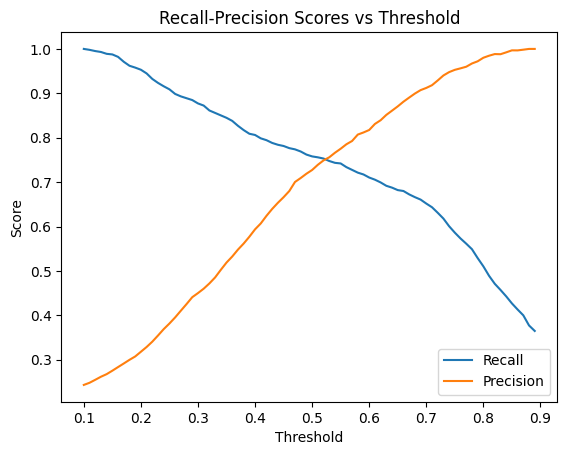

In [67]:
plot_threshold = threshold.visualize(estimator=loaded_model, X_test=X_test, y_test=y_test)

plot_threshold

In [128]:
thresh_init = ThresholdClassifier(estimator=loaded_model, threshold_point=0.52)

# create model with 0.52 threshold object
threshold_model = thresh_init.predict(X_test=X_test)
threshold_proba = thresh_init.predict_proba(X_test=X_test)

# save model
save_load.save_object(obj=thresh_init, path=config.MODEL_THRESHOLD_PATH)


Saving object. . . .
Your object has been saved succesfully and stored into: artifacts/model/threshold_model.pkl


In [129]:
# evaluate our threshold model
recall_threshold, precision_threshold, f1_threshold, roc_auc_threshold = evaluate_model.evaluate_test(y_test=y_test, y_pred=threshold_model, y_proba=threshold_proba)

In [133]:
# create summary non-tuned threshold and tuned threshold
threshold_summary = pd.DataFrame(data={
    'model': ['Non-tuned Threshold CatBoost SMOTE Model', 'Tuned Threshold CatBoost SMOTE Model'],
    'recall_score': [cb_smote_recall_test, recall_threshold],
    'precision_score': [cb_smote_precision_test, precision_threshold],
    'f1_score': [cb_smote_f1_test, f1_threshold],
    'roc_auc_score': [cb_smote_auc_test, roc_auc_threshold]
})

# show the table
threshold_summary.round(3)

,model,recall_score,precision_score,f1_score,roc_auc_score
0,Non-tuned Threshold CatBoost SMOTE Model,0.758,0.727,0.742,0.905
1,Tuned Threshold CatBoost SMOTE Model,0.753,0.749,0.751,0.905


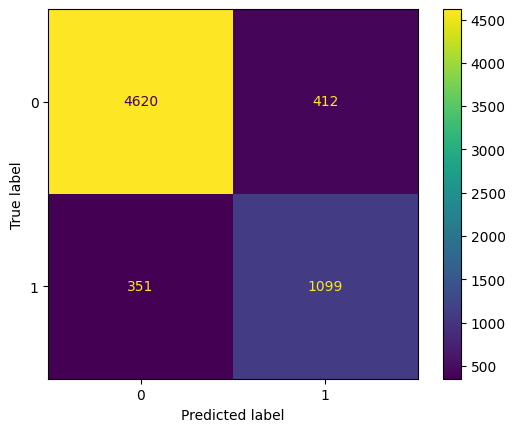

CatBoost No Threshold Tuning Confusion Matrix:
TN: 4620
FP: 412
FN: 351
TP: 1099


In [131]:
non_threshold_model_confusion, tn, fp, fn, tp = evaluate_model.confusion(y_test, y_cb_smote_pred)

print('CatBoost No Threshold Tuning Confusion Matrix:')
non_threshold_model_confusion
print('TN:', tn)
print('FP:', fp)
print('FN:', fn)
print('TP:', tp)

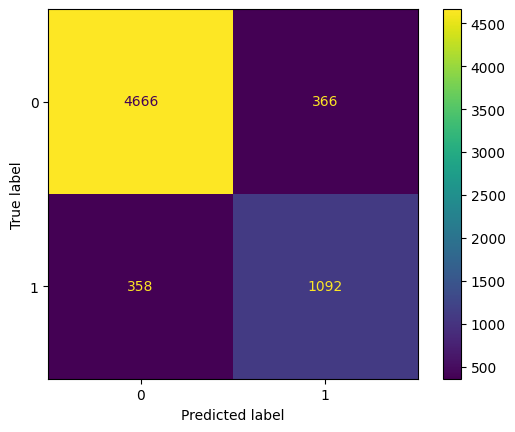

CatBoost Tuned-Threshold Confusion Matrix:
TN: 4666
FP: 366
FN: 358
TP: 1092


In [132]:
threshold_model_confusion, tn, fp, fn, tp = evaluate_model.confusion(y_test, thresh_init.predict(X_test))

print('CatBoost Tuned-Threshold Confusion Matrix:')
threshold_model_confusion
print('TN:', tn)
print('FP:', fp)
print('FN:', fn)
print('TP:', tp)